In [7]:
import numpy as np
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt
from sklearn.base import clone
from sklearn.datasets import load_wine,load_boston
from sklearn.model_selection import StratifiedKFold,cross_validate
from sklearn.metrics import accuracy_score,precision_score,recall_score,mean_absolute_error,mean_squared_error,r2_score,make_scorer
from abc import ABC,abstractmethod
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier

In [8]:
#base class for the random forest algorithm
class RandomForest(ABC):
    #initializer
    def __init__(self,n_trees=100):
        self.n_trees = n_trees
        self.trees   = []
    #private function to make bootstrap samples
    def __make_bootstraps(self,data):
        #initialize output dictionary & unique value count
        dc   = {}
        unip = 0
        #get sample size
        b_size = data.shape[0]
        #get list of row indexes
        idx = [i for i in range(b_size)]
        #loop through the required number of bootstraps
        for b in range(self.n_trees):
            #obtain boostrap samples with replacement
            sidx   = np.random.choice(idx,replace=True,size=b_size)
            b_samp = data[sidx,:]
            #compute number of unique values contained in the bootstrap sample
            unip  += len(set(sidx))
            #obtain out-of-bag samples for the current b
            oidx   = list(set(idx) - set(sidx))
            o_samp = np.array([])
            if oidx:
                o_samp = data[oidx,:]
            #store results
            dc['boot_'+str(b)] = {'boot':b_samp,'test':o_samp}
        #return the bootstrap results
        return(dc)

    #public function to return model parameters
    def get_params(self, deep = False):
        return {'n_trees':self.n_trees}

    #protected function to obtain the right decision tree
    @abstractmethod
    def _make_tree_model(self):
        pass
    
    #protected function to train the ensemble
    def _train(self,X_train,y_train):
        #package the input data
        training_data = np.concatenate((X_train,y_train.reshape(-1,1)),axis=1)
        #make bootstrap samples
        dcBoot = self.__make_bootstraps(training_data)
        #iterate through each bootstrap sample & fit a model ##
        tree_m = self._make_tree_model()
        dcOob    = {}
        for b in dcBoot:
            #make a clone of the model
            model = clone(tree_m)
            #fit a decision tree model to the current sample
            model.fit(dcBoot[b]['boot'][:,:-1],dcBoot[b]['boot'][:,-1].reshape(-1, 1))
            #append the fitted model
            self.trees.append(model)
            #store the out-of-bag test set for the current bootstrap
            if dcBoot[b]['test'].size:
                dcOob[b] = dcBoot[b]['test']
            else:
                dcOob[b] = np.array([])
        #return the oob data set
        return(dcOob)
      
    #protected function to predict from the ensemble
    def _predict(self,X):
        #check we've fit the ensemble
        if not self.trees:
            print('You must train the ensemble before making predictions!')
            return(None)
        #loop through each fitted model
        predictions = []
        for m in self.trees:
            #make predictions on the input X
            yp = m.predict(X)
            #append predictions to storage list
            predictions.append(yp.reshape(-1,1))
        #compute the ensemble prediction
        ypred = np.mean(np.concatenate(predictions,axis=1),axis=1)
        #return the prediction
        return(ypred)

In [9]:
#class for random forest classifier
class RandomForestClassifierCustom(RandomForest):
   #initializer
    def __init__(self,n_trees=100,max_depth: int=None,min_samples_split: int=2,criterion: str='gini',class_weights='balanced'):
        super().__init__(n_trees)
        self.max_depth             = max_depth
        self.min_samples_split     = min_samples_split
        self.criterion             = criterion
        self.class_weights         = class_weights

    #protected function to obtain the right decision tree
    def _make_tree_model(self):
        return(DecisionTreeClassifier(max_depth             = self.max_depth,
                                      min_samples_split     = self.min_samples_split,
                                      criterion             = self.criterion,
                                      class_weight          = self.class_weights))

    #public function to return model parameters
    def get_params(self, deep = False):
        return {'n_trees':self.n_trees,
                'max_depth':self.max_depth,
                'min_samples_split':self.min_samples_split,
                'criterion':self.criterion,
                'class_weights':self.class_weights}

    #train the ensemble
    def fit(self,X_train,y_train,print_metrics=False):
        #call the protected training method
        dcOob = self._train(X_train,y_train)
        #if selected, compute the standard errors and print them
        if print_metrics:
            #initialise metric arrays
            accs = np.array([])
            pres = np.array([])
            recs = np.array([])
            #loop through each bootstrap sample
            for b,m in zip(dcOob,self.trees):
                #compute the predictions on the out-of-bag test set & compute metrics
                if dcOob[b].size:
                    yp  = m.predict(dcOob[b][:,:-1])
                    acc = accuracy_score(dcOob[b][:,-1],yp)
                    pre = precision_score(dcOob[b][:,-1],yp,average='weighted')
                    rec = recall_score(dcOob[b][:,-1],yp,average='weighted')
                    #store the error metrics
                    accs = np.concatenate((accs,acc.flatten()))
                    pres = np.concatenate((pres,pre.flatten()))
                    recs = np.concatenate((recs,rec.flatten()))
            #print standard errors
            print("Standard error in accuracy: %.2f" % np.std(accs))
            print("Standard error in precision: %.2f" % np.std(pres))
            print("Standard error in recall: %.2f" % np.std(recs))

    #predict from the ensemble
    def predict(self,X):
        #call the protected prediction method
        ypred = self._predict(X)
        #convert the results into integer values & return
        return(np.round(ypred).astype(int))

Dimensions of X:  (178, 13)
Dimensions of y:  (178,)
Classes in the label:  [0 1 2]


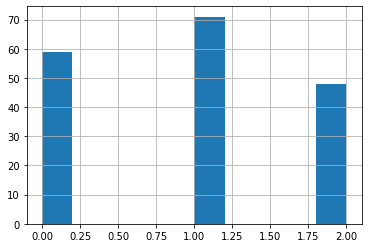

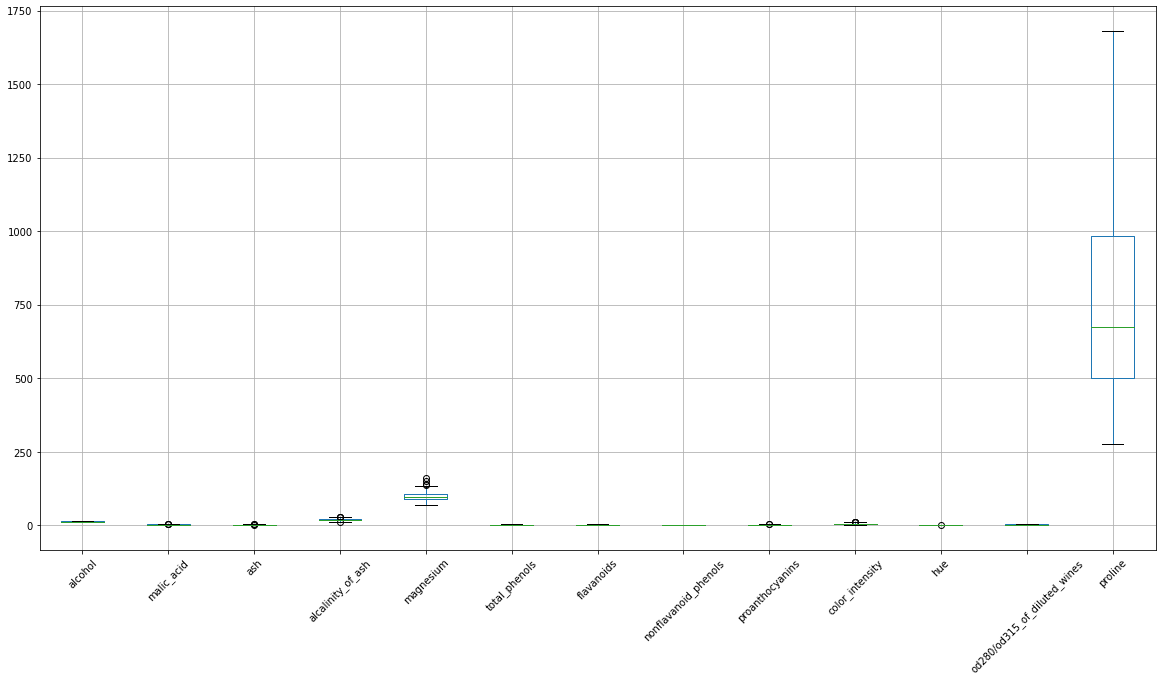

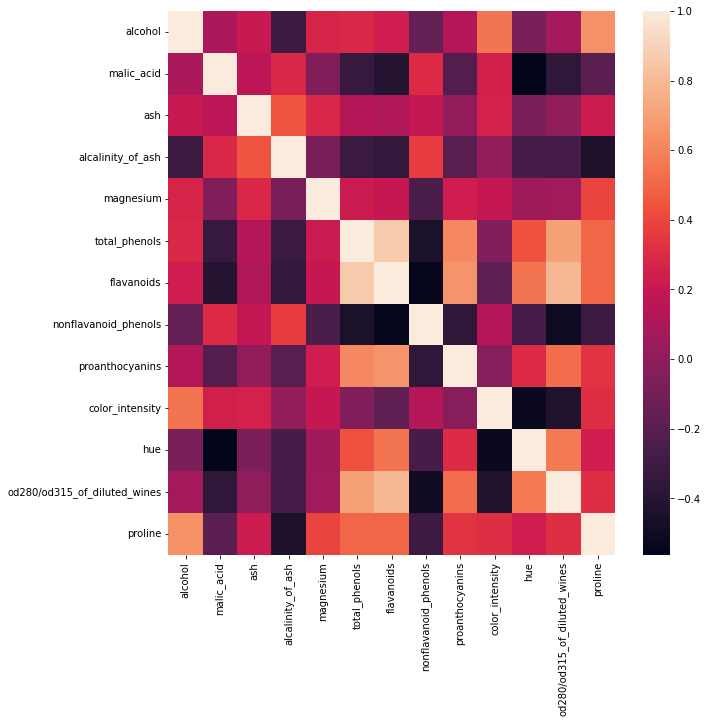

highly correlated input features:  total_phenols  &  ['flavanoids']
highly correlated input features:  flavanoids  &  ['total_phenols']
Mean Accuracy: 0.93
Mean Precision: 0.94
Mean Recall: 0.93


In [10]:
#load the wine dataset
dfX,sY = load_wine(return_X_y=True, as_frame=True)

#check the dimensions of these data
print('Dimensions of X: ',dfX.shape)
print('Dimensions of y: ',sY.shape)

#what unique classes exist in the label variable?
print('Classes in the label: ',sY.unique())

#what is the frequency of the classes in the dataset?
sY.hist()
plt.show()

#view the first 5 rows of input features
dfX.head(5)

#make a boxplot to view the distribution in these data
dfX.boxplot(figsize=(20,10),rot=45)
plt.show()

## plot the pearson correlation for our input features ##
fig, ax = plt.subplots(figsize = (10, 10))
dfCorr  = dfX.corr()
sn.heatmap(dfCorr)
plt.show()

#convert all correlations to positive values
dfCorr = dfCorr.abs()

#loop through rows
for index, sRow in dfCorr.iterrows():
    #get the valid entries
    sCorrs = sRow[sRow.index != index]
    sCorrs = sCorrs[sCorrs > 0.8]
    #print out results
    if not sCorrs.empty:
        print('highly correlated input features: ',index,' & ',sCorrs.index.values)

#create a random forest with balance class weights enabled
rfcC = RandomForestClassifierCustom(class_weights='balanced')

## train the ensemble & view estimates for prediction error ##
rfcC.fit(dfX.values,sY.values,print_metrics=False)

## use k fold cross validation to measure performance ##
scoring_metrics = {'accuracy': make_scorer(accuracy_score),
                   'precision': make_scorer(precision_score, average='weighted'),
                   'recall': make_scorer(recall_score, average='weighted')}
dcScores        = cross_validate(rfcC,dfX.values,sY.values,cv=StratifiedKFold(10),scoring=scoring_metrics)
print('Mean Accuracy: %.2f' % np.mean(dcScores['test_accuracy']))
print('Mean Precision: %.2f' % np.mean(dcScores['test_precision']))
print('Mean Recall: %.2f' % np.mean(dcScores['test_recall']))

In [11]:
#create a random forest with balanced class weights
rfc = RandomForestClassifier(class_weight='balanced')

## use k fold cross validation to measure performance ##
scoring_metrics = {'accuracy': make_scorer(accuracy_score),
                   'precision': make_scorer(precision_score, average='weighted'),
                   'recall': make_scorer(recall_score, average='weighted')}
dcScores        = cross_validate(rfc,dfX.values,sY.values,cv=StratifiedKFold(10),scoring=scoring_metrics)
print('Mean Accuracy: %.2f' % np.mean(dcScores['test_accuracy']))
print('Mean Precision: %.2f' % np.mean(dcScores['test_precision']))
print('Mean Recall: %.2f' % np.mean(dcScores['test_recall']))

Mean Accuracy: 0.97
Mean Precision: 0.98
Mean Recall: 0.97
